# **Libraries & Constants**

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Activation, add, concatenate
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import os
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from copy import deepcopy
from PIL import Image
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/AI Projects/Meta-learning vision project/mhsma-dataset sperm images/mhsma/"

# **Preprocessing**

In [ ]:
# import dataset from path
x_train = np.load(data_path + 'x_128_train.npy')
x_dev = np.load(data_path + 'x_128_valid.npy')
x_test = np.load(data_path + 'x_128_test.npy')

y_acrosome_train = np.load(data_path + 'y_acrosome_train.npy').reshape(-1, 1)
y_acrosome_dev = np.load(data_path + 'y_acrosome_valid.npy').reshape(-1, 1)
y_acrosome_test = np.load(data_path + 'y_acrosome_test.npy').reshape(-1, 1)

In [ ]:
print('x_train.shape: ', x_train.shape)
print('x_dev.shape: ', x_dev.shape)
print('x_test.shape: ', x_test.shape)
print('y_acrosome_test.shape: ', y_acrosome_train.shape)

x_train.shape:  (1000, 128, 128)
x_dev.shape:  (240, 128, 128)
x_test.shape:  (300, 128, 128)
y_acrosome_test.shape:  (1000, 1)


Example

[1]


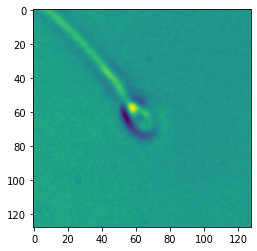

In [ ]:
plt.imshow(x_train[30])
print(y_acrosome_train[30])